In [4]:
import sqlite3
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import re
import pymorphy2
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Alexey\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
stopwords = set(nltk.corpus.stopwords.words("russian"))
morph = pymorphy2.MorphAnalyzer()

In [9]:
from typing import List

con = sqlite3.connect("predictor.db")
cur = con.cursor()

cur.execute("SELECT text, label FROM posts")
text, label = cur.fetchone()

def get_text_length(text: str):
    words = text.lower().split()
    words_of_letters = map(keep_letters, words)
    nonempty_words = filter(None, words_of_letters)
    length = len(list(nonempty_words))
    if length < 5 or length > 600: return -1
    return length

def preprocess_text(text: str, morph, stop_words) -> List[str]:
    words = text.lower().split()
    words_of_letters = map(keep_letters, words)
    nonempty_words = filter(None, words_of_letters)
    normalized_words = map(normalize_word, nonempty_words)
    preprocessed_words = filter(lambda word: word not in stop_words, normalized_words)
    return list(preprocessed_words)

def keep_letters(word: str) -> str:
    return re.sub(r"[^а-я]", "", word)

def normalize_word(word: str, morph=morph) -> str:
    return morph.parse(word)[0].normal_form

class_counters = {0: 0,
                  1: 0,
                  2: 0}

#class_labels = {0: "cooking",
#                1: "fashion",
#                2: "animal"}
text_counter = 0
    
unique_words = set()
for text, label in cur:
    preprocessed_words = preprocess_text(text, morph, stopwords)
    text_counter += 1
    if (text_counter % 1000 == 0):
        print(f"Progress: {text_counter / 15000}")
    if len(preprocessed_words) > 0:
        for word in preprocessed_words:
            if word not in unique_words:
                unique_words.add(word)
        class_counters[label] += 1
        filepath = f"dataset/class_{label}/{label}_text_{class_counters[label]}.txt"
        with open(filepath, "w", encoding="utf-8") as file:
            file.write(" ".join(preprocessed_words))
        
print(class_counters)
print(len(unique_words))

Progress: 0.06666666666666667
Progress: 0.13333333333333333
Progress: 0.2
Progress: 0.26666666666666666
Progress: 0.3333333333333333
Progress: 0.4
Progress: 0.4666666666666667
Progress: 0.5333333333333333
Progress: 0.6
Progress: 0.6666666666666666
Progress: 0.7333333333333333
Progress: 0.8
Progress: 0.8666666666666667
Progress: 0.9333333333333333
{0: 4871, 1: 4625, 2: 4496}
55049


In [8]:
BUFFER_SIZE = 10000
BATCH_SIZE = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE
dataset = tf.keras.utils.text_dataset_from_directory("dataset")
dataset = dataset.shuffle(BUFFER_SIZE).prefetch(AUTOTUNE)

def is_test(index, value):
    return index % 4 == 0

def is_train(index, value):
    return index % 4 != 0

def split_dataset(dataset):
    recover = lambda index, value: value
    test_dataset = dataset.enumerate() \
                            .filter(is_test) \
                            .map(recover)
    train_dataset = dataset.enumerate() \
                            .filter(is_train) \
                            .map(recover)
    return train_dataset, test_dataset

train, test = split_dataset(dataset)

VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train.map(lambda text, label: text))
vocab = np.array(encoder.get_vocabulary())
with open("vocabulary.txt", "w", encoding="utf-8") as file:
    for word in vocab:
        file.write(word + '\n')

Found 13992 files belonging to 3 classes.


In [11]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3)
])

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])
history = model.fit(train, epochs=10,
                    validation_data=test,
                    validation_steps=30)

Epoch 1/10
328/328 [==============================] - 139s 402ms/step - loss: 0.7091 - accuracy: 0.7777 - val_loss: 0.4686 - val_accuracy: 0.8573
Epoch 2/10
328/328 [==============================] - 139s 415ms/step - loss: 0.3645 - accuracy: 0.8909 - val_loss: 0.2746 - val_accuracy: 0.9167
Epoch 3/10
328/328 [==============================] - 131s 390ms/step - loss: 0.2494 - accuracy: 0.9166 - val_loss: 0.2101 - val_accuracy: 0.9250
Epoch 4/10
328/328 [==============================] - 134s 400ms/step - loss: 0.1798 - accuracy: 0.9319 - val_loss: 0.1482 - val_accuracy: 0.9396
Epoch 5/10
328/328 [==============================] - 133s 396ms/step - loss: 0.1488 - accuracy: 0.9438 - val_loss: 0.1234 - val_accuracy: 0.9521
Epoch 6/10
328/328 [==============================] - 133s 398ms/step - loss: 0.1228 - accuracy: 0.9520 - val_loss: 0.1073 - val_accuracy: 0.9635
Epoch 7/10
328/328 [==============================] - 138s 410ms/step - loss: 0.1107 - accuracy: 0.9578 - val_loss: 0.1007 -

In [12]:
model.save_weights("weights")
model.save("predictor_model.keras")

NotImplementedError: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Received a model or layer TextVectorization with weights [<keras.layers.preprocessing.index_lookup.VocabWeightHandler object at 0x000002070FBE4BE0>]

110/110 [==============================] - 12s 92ms/step - loss: 0.1005 - accuracy: 0.9620
Test Loss: 0.10047059506177902
Test Accuracy: 0.9619565010070801


(0.0, 0.7402668293565512)

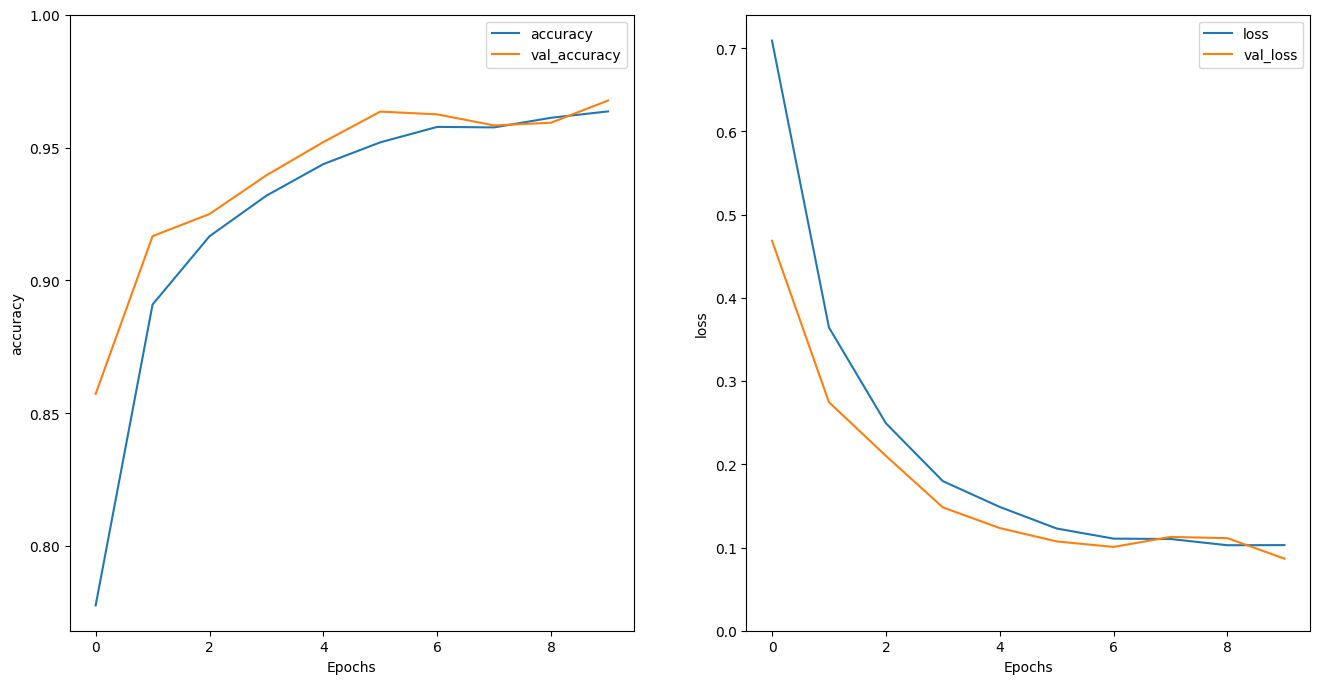

In [15]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

test_loss ,test_acc = model.evaluate(test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [20]:
with open("unique_words.txt", "w", encoding="utf-8") as file:
     file.writelines(word+'\n' for word in unique_words)